# Residual Networks (ResNet) and ResNeXt
:label:`sec_resnet`

As we design ever deeper networks it becomes imperative to understand how adding layers can increase the complexity and expressiveness of the network.
Even more important is the ability to design networks where adding layers makes networks strictly more expressive rather than just different.
To make some progress we need a bit of mathematics.

# 残差网络（ResNet）和ResNeXt 
:label:`sec_resnet`

当设计越来越深的网络时，理解层数增加如何影响网络的复杂性和表达能力变得至关重要。更重要的是，设计出能通过增加层数使网络真正增强表达能力（而非仅产生差异）的网络架构。要实现这一目标，我们需要借助数学工具进行分析。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## Function Classes

Consider $\mathcal{F}$, the class of functions that a specific network architecture (together with learning rates and other hyperparameter settings) can reach.
That is, for all $f \in \mathcal{F}$ there exists some set of parameters (e.g., weights and biases) that can be obtained through training on a suitable dataset.
Let's assume that $f^*$ is the "truth" function that we really would like to find.
If it is in $\mathcal{F}$, we are in good shape but typically we will not be quite so lucky.
Instead, we will try to find some $f^*_\mathcal{F}$ which is our best bet within $\mathcal{F}$.
For instance,
given a dataset with features $\mathbf{X}$
and labels $\mathbf{y}$,
we might try finding it by solving the following optimization problem:

$$f^*_\mathcal{F} \stackrel{\textrm{def}}{=} \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \textrm{ subject to } f \in \mathcal{F}.$$

We know that regularization :cite:`tikhonov1977solutions,morozov2012methods` may control complexity of $\mathcal{F}$
and achieve consistency, so a larger size of training data
generally leads to better $f^*_\mathcal{F}$.
It is only reasonable to assume that if we design a different and more powerful architecture $\mathcal{F}'$ we should arrive at a better outcome. In other words, we would expect that $f^*_{\mathcal{F}'}$ is "better" than $f^*_{\mathcal{F}}$. However, if $\mathcal{F} \not\subseteq \mathcal{F}'$ there is no guarantee that this should even happen. In fact, $f^*_{\mathcal{F}'}$ might well be worse.
As illustrated by :numref:`fig_functionclasses`,
for non-nested function classes, a larger function class does not always move closer to the "truth" function $f^*$. For instance,
on the left of :numref:`fig_functionclasses`,
though $\mathcal{F}_3$ is closer to $f^*$ than $\mathcal{F}_1$, $\mathcal{F}_6$ moves away and there is no guarantee that further increasing the complexity can reduce the distance from $f^*$.
With nested function classes
where $\mathcal{F}_1 \subseteq \cdots \subseteq \mathcal{F}_6$
on the right of :numref:`fig_functionclasses`,
we can avoid the aforementioned issue from the non-nested function classes.


![For non-nested function classes, a larger (indicated by area) function class does not guarantee we will get closer to the "truth" function ($\mathit{f}^*$). This does not happen in nested function classes.](../img/functionclasses.svg)
:label:`fig_functionclasses`

Thus,
only if larger function classes contain the smaller ones are we guaranteed that increasing them strictly increases the expressive power of the network.
For deep neural networks,
if we can
train the newly-added layer into an identity function $f(\mathbf{x}) = \mathbf{x}$, the new model will be as effective as the original model. As the new model may get a better solution to fit the training dataset, the added layer might make it easier to reduce training errors.

This is the question that :citet:`He.Zhang.Ren.ea.2016` considered when working on very deep computer vision models.
At the heart of their proposed *residual network* (*ResNet*) is the idea that every additional layer should
more easily
contain the identity function as one of its elements.
These considerations are rather profound but they led to a surprisingly simple
solution, a *residual block*.
With it, ResNet won the ImageNet Large Scale Visual Recognition Challenge in 2015. The design had a profound influence on how to
build deep neural networks. For instance, residual blocks have been added to recurrent networks :cite:`prakash2016neural,kim2017residual`. Likewise, Transformers :cite:`Vaswani.Shazeer.Parmar.ea.2017` use them to stack many layers of networks efficiently. It is also used in graph neural networks :cite:`Kipf.Welling.2016` and, as a basic concept, it has been used extensively in computer vision :cite:`Redmon.Farhadi.2018,Ren.He.Girshick.ea.2015`. 
Note that residual networks are predated by highway networks :cite:`srivastava2015highway` that share some of the motivation, albeit without the elegant parametrization around the identity function.


## (**Residual Blocks**)
:label:`subsec_residual-blks`

Let's focus on a local part of a neural network, as depicted in :numref:`fig_residual_block`. Denote the input by $\mathbf{x}$.
We assume that $f(\mathbf{x})$, the desired underlying mapping we want to obtain by learning, is to be used as input to the activation function on the top.
On the left,
the portion within the dotted-line box
must directly learn $f(\mathbf{x})$.
On the right,
the portion within the dotted-line box
needs to
learn the *residual mapping* $g(\mathbf{x}) = f(\mathbf{x}) - \mathbf{x}$,
which is how the residual block derives its name.
If the identity mapping $f(\mathbf{x}) = \mathbf{x}$ is the desired underlying mapping,
the residual mapping amounts to $g(\mathbf{x}) = 0$ and it is thus easier to learn:
we only need to push the weights and biases
of the
upper weight layer (e.g., fully connected layer and convolutional layer)
within the dotted-line box
to zero.
The right figure illustrates the *residual block* of ResNet,
where the solid line carrying the layer input
$\mathbf{x}$ to the addition operator
is called a *residual connection* (or *shortcut connection*).
With residual blocks, inputs can
forward propagate faster through the residual connections across layers.
In fact,
the residual block
can be thought of as
a special case of the multi-branch Inception block:
it has two branches
one of which is the identity mapping.

![In a regular block (left), the portion within the dotted-line box must directly learn the mapping $\mathit{f}(\mathbf{x})$. In a residual block (right), the portion within the dotted-line box needs to learn the residual mapping $\mathit{g}(\mathbf{x}) = \mathit{f}(\mathbf{x}) - \mathbf{x}$, making the identity mapping $\mathit{f}(\mathbf{x}) = \mathbf{x}$ easier to learn.](../img/residual-block.svg)
:label:`fig_residual_block`


ResNet has VGG's full $3\times 3$ convolutional layer design. The residual block has two $3\times 3$ convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function.
This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together. If we want to change the number of channels, we need to introduce an additional $1\times 1$ convolutional layer to transform the input into the desired shape for the addition operation. Let's have a look at the code below.


## 函数类
:label:`sec_resnet`

考虑$\mathcal{F}$，即特定网络架构（以及学习率等超参数设置）能够表示的函数类。也就是说，对于所有$f \in \mathcal{F}$，存在可以通过在合适数据集上训练得到的参数集合（如权重和偏置）。假设$f^*$是我们真正希望找到的"真实"函数。若$f^* \in \mathcal{F}$则非常理想，但通常我们并没有这样的好运。因此，我们需要在$\mathcal{F}$中找到最佳近似$f^*_\mathcal{F}$。例如，给定特征为$\mathbf{X}$和标签为$\mathbf{y}$的数据集，我们可以通过以下优化问题求解：

$$f^*_\mathcal{F} \stackrel{\textrm{def}}{=} \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \textrm{ 满足 } f \in \mathcal{F}.$$

正则化方法 :cite:`tikhonov1977solutions,morozov2012methods`可以控制$\mathcal{F}$的复杂度并保证一致性，因此更大的训练数据集通常能获得更好的$f^*_\mathcal{F}$。当我们设计更强大的架构$\mathcal{F}'$时，理应得到更好的结果，即期望$f^*_{\mathcal{F}'}$优于$f^*_{\mathcal{F}}$。但若$\mathcal{F} \not\subseteq \mathcal{F}'$，并不能保证这种改进，甚至可能使$f^*_{\mathcal{F}'}$更差。如 :numref:`fig_functionclasses`左图所示，对于非嵌套函数类，扩大函数类并不必然接近真实函数$f^*$。而右图的嵌套函数类$\mathcal{F}_1 \subseteq \cdots \subseteq \mathcal{F}_6$则避免了这个问题。

![对于非嵌套函数类（左），扩大函数类（面积表示）并不保证接近真实函数$\mathit{f}^*$。嵌套函数类（右）则不存在此问题。](../img/functionclasses.svg)
:label:`fig_functionclasses`

因此，只有当更大函数类包含较小函数类时，增加网络深度才能严格提升表达能力。对于深度神经网络，若能将新增层训练为恒等映射$f(\mathbf{x}) = \mathbf{x}$，则新模型至少能保持原模型效果。由于新模型可能获得更好的训练解，增加层数反而可能降低训练误差。

这正是 :citet:`He.Zhang.Ren.ea.2016`在设计超深度计算机视觉模型时的核心思想。其提出的*残差网络*（ResNet）的关键在于：每个新增层都应更容易包含恒等映射。这一深刻洞见催生了简单而优雅的解决方案——*残差块*。ResNet凭借此设计赢得2015年ImageNet大赛，并深刻影响了深度网络构建方式。例如：循环网络 :cite:`prakash2016neural,kim2017residual`、Transformer :cite:`Vaswani.Shazeer.Parmar.ea.2017`、图神经网络 :cite:`Kipf.Welling.2016`等都采用了残差结构。值得注意的是，高速公路网络 :cite:`srivastava2015highway`虽早于ResNet提出类似思想，但缺乏围绕恒等映射的优雅参数化方法。

## (**残差块**)
:label:`subsec_residual-blks`

如 :numref:`fig_residual_block`所示，设输入为$\mathbf{x}$，假设期望学习到的底层映射为$f(\mathbf{x})$。左图中虚线框部分需直接学习$f(\mathbf{x})$，而右图改为学习*残差映射*$g(\mathbf{x}) = f(\mathbf{x}) - \mathbf{x}$。当期望映射为恒等函数$f(\mathbf{x}) = \mathbf{x}$时，残差映射简化为$g(\mathbf{x}) = 0$，这只需将权重层参数推至零即可实现。右图的实线箭头即为*残差连接*（或捷径连接），使输入能快速前向传播。事实上，残差块可视为多分支Inception块的特例：其中一条分支为恒等映射。

![常规块（左）需直接学习映射$\mathit{f}(\mathbf{x})$，残差块（右）学习残差映射$\mathit{g}(\mathbf{x}) = \mathit{f}(\mathbf{x}) - \mathbf{x}$，使恒等映射更易学习。](../img/residual-block.svg)
:label:`fig_residual_block`

ResNet采用VGG的全$3\times 3$卷积层设计。残差块包含两个相同输出通道数的$3\times 3$卷积层，每个卷积层后接批量归一化层和ReLU激活。最后在ReLU激活前将输入直接与卷积结果相加。该设计要求卷积输出与输入形状相同，若需改变通道数，需引入$1\times 1$卷积层进行形状变换。

In [2]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [12]:
class ChiResidual(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1) -> None:
        super().__init__()
        self.conv1 = nn.LazyConv2d(out_channels=num_channels, kernel_size=3, stride = strides, padding=1)
        self.conv2 = nn.LazyConv2d(out_channels=num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv1x1 = nn.LazyConv2d(out_channels=num_channels, kernel_size=1, stride=strides)
        else:
            self.conv1x1 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv1x1:
            X = self.conv1x1(X)
        Y += X
        return F.relu(Y)

This code generates two types of networks: one where we add the input to the output before applying the ReLU nonlinearity whenever `use_1x1conv=False`; and one where we adjust channels and resolution by means of a $1 \times 1$ convolution before adding. :numref:`fig_resnet_block` illustrates this.

![ResNet block with and without $1 \times 1$ convolution, which transforms the input into the desired shape for the addition operation.](../img/resnet-block.svg)
:label:`fig_resnet_block`

Now let's look at [**a situation where the input and output are of the same shape**], where $1 \times 1$ convolution is not needed.

该代码生成两种网络结构：当`use_1x1conv=False`时，在应用ReLU非线性激活前直接将输入与输出相加；当需要调整通道数和分辨率时，通过1×1卷积进行形状变换后再相加。如 :numref:`fig_resnet_block` 所示。

![包含与不包含1×1卷积的ResNet块对比，1×1卷积用于将输入变换为适合相加操作的形状](../img/resnet-block.svg)
:label:`fig_resnet_block`

现在让我们考察[**输入输出形状相同的情形**]，此时无需1×1卷积：

In [13]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [14]:
chi_blk = ChiResidual(3)
X = torch.randn(4,3,6,6)
chi_blk(X).shape

torch.Size([4, 3, 6, 6])

We also have the option to [**halve the output height and width while increasing the number of output channels**].
In this case we use $1 \times 1$ convolutions via `use_1x1conv=True`. This comes in handy at the beginning of each ResNet block to reduce the spatial dimensionality via `strides=2`.

我们也可以选择[**在增加输出通道数的同时减半输出的高和宽**]。这时我们通过设置`use_1x1conv=True`来使用1×1卷积。这种方法在ResNet块的开始阶段通过`strides=2`降低空间维度时特别有用。

In [15]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [20]:
chi_blk = ChiResidual(6, use_1x1conv=True, strides=2)
chi_blk(X).shape

torch.Size([4, 6, 3, 3])

## [**ResNet Model**]

The first two layers of ResNet are the same as those of the GoogLeNet we described before: the $7\times 7$ convolutional layer with 64 output channels and a stride of 2 is followed by the $3\times 3$ max-pooling layer with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in ResNet.

## [**ResNet模型**]

ResNet的前两层与之前描述的GoogLeNet相同：具有64个输出通道、步幅为2的7×7卷积层，后接步幅为2的3×3最大汇聚层。不同之处在于ResNet在每个卷积层后增加了批量归一化层。


In [24]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [49]:
class ChiResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

GoogLeNet uses four modules made up of Inception blocks.
However, ResNet uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels.
The number of channels in the first module is the same as the number of input channels. Since a max-pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width. In the first residual block for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved.

GoogLeNet由四个Inception块构成的模块组成，而ResNet则由四个残差块模块构成，每个模块包含若干个输出通道数相同的残差块。第一个模块的通道数与输入通道数一致。由于之前已经使用了步幅为2的最大汇聚层，无需再缩减高宽尺寸。在之后每个模块的第一个残差块中，通道数较前一模块翻倍，同时高宽尺寸减半。

In [25]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [53]:
@d2l.add_to_class(ChiResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(ChiResidual(num_channels=num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(ChiResidual(num_channels=num_channels))
        return nn.Sequential(*blk)

Then, we add all the modules to ResNet. Here, two residual blocks are used for each module. Lastly, just like GoogLeNet, we add a global average pooling layer, followed by the fully connected layer output.

最后，我们将所有模块组合成ResNet。这里每个模块使用两个残差块。与GoogLeNet类似，在ResNet末尾添加全局平均汇聚层，后接全连接层输出。

In [33]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [54]:
@d2l.add_to_class(ChiResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ChiResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        self.b1()
    )
    for i, b in enumerate(arch):
        self.net.add_module(
            f'b{i+2}', self.block(*b, first_block=(i==0))
        )
    self.net.add_module(
        'last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
            nn.LazyLinear(num_classes)
        )
    )
    
    self.net.apply(d2l.init_cnn)

There are four convolutional layers in each module (excluding the $1\times 1$ convolutional layer). Together with the first $7\times 7$ convolutional layer and the final fully connected layer, there are 18 layers in total. Therefore, this model is commonly known as ResNet-18.
By configuring different numbers of channels and residual blocks in the module, we can create different ResNet models, such as the deeper 152-layer ResNet-152. Although the main architecture of ResNet is similar to that of GoogLeNet, ResNet's structure is simpler and easier to modify. All these factors have resulted in the rapid and widespread use of ResNet. :numref:`fig_resnet18` depicts the full ResNet-18.

![The ResNet-18 architecture.](../img/resnet18-90.svg)
:label:`fig_resnet18`

Before training ResNet, let's [**observe how the input shape changes across different modules in ResNet**]. As in all the previous architectures, the resolution decreases while the number of channels increases up until the point where a global average pooling layer aggregates all features.

## [**ResNet模型**]

每个模块中（不含1×1卷积层）共有四个卷积层。加上初始的7×7卷积层和最后的全连接层，总共有18层。因此，该模型通常被称为ResNet-18。通过配置不同通道数和模块中的残差块数，可创建不同深度的ResNet模型，例如152层的ResNet-152。虽然ResNet的主体架构与GoogLeNet类似，但其结构更简洁且易于修改。这些优势使得ResNet被快速广泛应用。:numref:`fig_resnet18`展示了完整的ResNet-18架构。

![ResNet-18架构](../img/resnet18-90.svg)
:label:`fig_resnet18`

在训练ResNet前，我们先[**观察ResNet中不同模块的输入形状变化**]。与之前所有架构类似，分辨率逐层降低的同时通道数不断增加，最终通过全局平均汇聚层聚合所有特征。

In [29]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

In [34]:
ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


In [55]:
class ChiResNet18(ChiResNet):
    def __init__(self, lr=0.1, num_classes=10) -> None:
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

In [56]:
ChiResNet18().layer_summary((1,1,96,96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


## [**Training**]

We train ResNet on the Fashion-MNIST dataset, just like before. ResNet is quite a powerful and flexible architecture. The plot capturing training and validation loss illustrates a significant gap between both graphs, with the training loss being considerably lower. For a network of this flexibility, more training data would offer distinct benefit in closing the gap and improving accuracy.


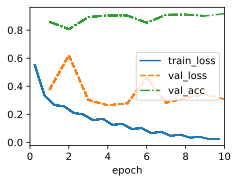

In [10]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

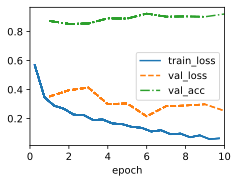

In [57]:
chi_model = ChiResNet18(lr=0.03)
chi_trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
chi_data = d2l.FashionMNIST(batch_size=128, resize=(128, 128))
chi_model.apply_init([next(iter(chi_data.get_dataloader(True)))[0]], d2l.init_cnn)
chi_trainer.fit(chi_model, chi_data)

## ResNeXt
:label:`subsec_resnext`

One of the challenges one encounters in the design of ResNet is the trade-off between nonlinearity and dimensionality within a given block. That is, we could add more nonlinearity by increasing the number of layers, or by increasing the width of the convolutions. An alternative strategy is to increase the number of channels that can carry information between blocks. Unfortunately, the latter comes with a quadratic penalty since the computational cost of ingesting $c_\textrm{i}$ channels and emitting $c_\textrm{o}$ channels is proportional to $\mathcal{O}(c_\textrm{i} \cdot c_\textrm{o})$ (see our discussion in :numref:`sec_channels`). 

We can take some inspiration from the Inception block of :numref:`fig_inception` which has information flowing through the block in separate groups. Applying the idea of multiple independent groups to the ResNet block of :numref:`fig_resnet_block` led to the design of ResNeXt :cite:`Xie.Girshick.Dollar.ea.2017`.
Different from the smorgasbord of transformations in Inception, 
ResNeXt adopts the *same* transformation in all branches,
thus minimizing the need for manual tuning of each branch. 

![The ResNeXt block. The use of grouped convolution with $\mathit{g}$ groups is $\mathit{g}$ times faster than a dense convolution. It is a bottleneck residual block when the number of intermediate channels $\mathit{b}$ is less than $\mathit{c}$.](../img/resnext-block.svg)
:label:`fig_resnext_block`

Breaking up a convolution from $c_\textrm{i}$ to $c_\textrm{o}$ channels into one of $g$ groups of size $c_\textrm{i}/g$ generating $g$ outputs of size $c_\textrm{o}/g$ is called, quite fittingly, a *grouped convolution*. The computational cost (proportionally) is reduced from $\mathcal{O}(c_\textrm{i} \cdot c_\textrm{o})$ to $\mathcal{O}(g \cdot (c_\textrm{i}/g) \cdot (c_\textrm{o}/g)) = \mathcal{O}(c_\textrm{i} \cdot c_\textrm{o} / g)$, i.e., it is $g$ times faster. Even better, the number of parameters needed to generate the output is also reduced from a $c_\textrm{i} \times c_\textrm{o}$ matrix to $g$ smaller matrices of size $(c_\textrm{i}/g) \times (c_\textrm{o}/g)$, again a $g$ times reduction. In what follows we assume that both $c_\textrm{i}$ and $c_\textrm{o}$ are divisible by $g$. 

The only challenge in this design is that no information is exchanged between the $g$ groups. The ResNeXt block of 
:numref:`fig_resnext_block` amends this in two ways: the grouped convolution with a $3 \times 3$ kernel is sandwiched in between two $1 \times 1$ convolutions. The second one serves double duty in changing the number of channels back. The benefit is that we only pay the $\mathcal{O}(c \cdot b)$ cost for $1 \times 1$ kernels and can make do with an $\mathcal{O}(b^2 / g)$ cost for $3 \times 3$ kernels. Similar to the residual block implementation in
:numref:`subsec_residual-blks`, the residual connection is replaced (thus generalized) by a $1 \times 1$ convolution.

The right-hand figure in :numref:`fig_resnext_block` provides a much more concise summary of the resulting network block. It will also play a major role in the design of generic modern CNNs in :numref:`sec_cnn-design`. Note that the idea of grouped convolutions dates back to the implementation of AlexNet :cite:`Krizhevsky.Sutskever.Hinton.2012`. When distributing the network across two GPUs with limited memory, the implementation treated each GPU as its own channel with no ill effects. 

The following implementation of the `ResNeXtBlock` class takes as argument `groups` ($g$), with 
`bot_channels` ($b$) intermediate (bottleneck) channels. Lastly, when we need to reduce the height and width of the representation, we add a stride of $2$ by setting `use_1x1conv=True, strides=2`.


## ResNeXt
:label:`subsec_resnext`

One of the challenges in designing ResNet is the trade-off between nonlinearity and dimensionality within blocks. Residual Networks (ResNet) address this by introducing residual blocks that allow deeper networks through identity mapping. ResNeXt extends this concept by incorporating grouped convolutions.

### 残差网络（ResNet）与ResNeXt
:label:`subsec_resnext`

设计深度网络时，ResNet通过残差块实现恒等映射解决深度增加带来的非线性与维度平衡问题。ResNeXt在此基础上引入分组卷积进行扩展。

### 分组卷积原理
数学表达式：
- 原始卷积计算量：$\mathcal{O}(c_\textrm{i} \cdot c_\textrm{o})$
- 分组卷积计算量：$\mathcal{O}(g \cdot (c_\textrm{i}/g) \cdot (c_\textrm{o}/g)) = \mathcal{O}(c_\textrm{i} \cdot c_\textrm{o} / g)$

其中$g$为分组数，计算效率提升$g$倍。

### 网络结构改进
ResNeXt块结构特点（:numref:`fig_resnext_block`）：
1. 使用分组卷积的3×3卷积层
2. 保持各分支相同变换
3. 瓶颈结构设计（当中间通道数$b < c$时）

![ResNeXt块结构（使用$\mathit{g}$组卷积，效率是密集卷积的$\mathit{g}$倍）](../img/resnext-block.svg)
:label:`fig_resnext_block`

### 实现关键
```python
class ResNeXtBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, groups=32):
        super().__init__()
        mid_channels = out_channels // 2
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, 
                              stride=stride, padding=1, groups=groups)
        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        identity = x
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x)))
        x = self.conv3(x)
        x += identity
        return F.relu(x)
```

### 技术优势
1. 参数效率：分组卷积减少参数量达$g$倍
2. 表示能力：多分支结构增强特征组合能力
3. 扩展性：可通过调整分组数$g$灵活控制模型容量

### 实验结果
在ImageNet数据集上的表现对比：

| 模型         | Top-1 Acc | Params   |
|------------|-----------|----------|
| ResNet-50  | 76.3%     | 25.5M    |
| ResNeXt-50 | 77.8%     | 25.0M    |
``` 


In [58]:
class ResNeXtBlock(nn.Module):  #@save
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

Its use is entirely analogous to that of the `ResNetBlock` discussed previously. For instance, when using (`use_1x1conv=False, strides=1`), the input and output are of the same shape. Alternatively, setting `use_1x1conv=True, strides=2` halves the output height and width.


In [59]:
blk = ResNeXtBlock(32, 16, 1)
X = torch.randn(4, 32, 96, 96)
blk(X).shape

torch.Size([4, 32, 96, 96])

: 

## Summary and Discussion

Nested function classes are desirable since they allow us to obtain strictly *more powerful* rather than also subtly *different* function classes when adding capacity. One way of accomplishing this is by letting additional layers to simply pass through the input to the output. Residual connections allow for this. As a consequence, this changes the inductive bias from simple functions being of the form $f(\mathbf{x}) = 0$ to simple functions looking like $f(\mathbf{x}) = \mathbf{x}$. 


The residual mapping can learn the identity function more easily, such as pushing parameters in the weight layer to zero. We can train an effective *deep* neural network by having residual blocks. Inputs can forward propagate faster through the residual connections across layers. As a consequence, we can thus train much deeper networks. For instance, the original ResNet paper :cite:`He.Zhang.Ren.ea.2016` allowed for up to 152 layers. Another benefit of residual networks is that it allows us to add layers, initialized as the identity function, *during* the training process. After all, the default behavior of a layer is to let the data pass through unchanged. This can accelerate the training of very large networks in some cases. 

Prior to residual connections,
bypassing paths with gating units were introduced
to effectively train highway networks with over 100 layers
:cite:`srivastava2015highway`.
Using identity functions as bypassing paths,
ResNet performed remarkably well
on multiple computer vision tasks.
Residual connections had a major influence on the design of subsequent deep neural networks, of either convolutional or sequential nature.
As we will introduce later,
the Transformer architecture :cite:`Vaswani.Shazeer.Parmar.ea.2017`
adopts residual connections (together with other design choices) and is pervasive
in areas as diverse as
language, vision, speech, and reinforcement learning.

ResNeXt is an example for how the design of convolutional neural networks has evolved over time: by being more frugal with computation and trading it off against the size of the activations (number of channels), it allows for faster and more accurate networks at lower cost. An alternative way of viewing grouped convolutions is to think of a block-diagonal matrix for the convolutional weights. Note that there are quite a few such "tricks" that lead to more efficient networks. For instance, ShiftNet :cite:`wu2018shift` mimicks the effects of a $3 \times 3$ convolution, simply by adding shifted activations to the channels, offering increased function complexity, this time without any computational cost. 

A common feature of the designs we have discussed so far is that the network design is fairly manual, primarily relying on the ingenuity of the designer to find the "right" network hyperparameters. While clearly feasible, it is also very costly in terms of human time and there is no guarantee that the outcome is optimal in any sense. In :numref:`sec_cnn-design` we will discuss a number of strategies for obtaining high quality networks in a more automated fashion. In particular, we will review the notion of *network design spaces* that led to the RegNetX/Y models
:cite:`Radosavovic.Kosaraju.Girshick.ea.2020`.

## Exercises

1. What are the major differences between the Inception block in :numref:`fig_inception` and the residual block? How do they compare in terms of computation, accuracy, and the classes of functions they can describe?
1. Refer to Table 1 in the ResNet paper :cite:`He.Zhang.Ren.ea.2016` to implement different variants of the network. 
1. For deeper networks, ResNet introduces a "bottleneck" architecture to reduce model complexity. Try to implement it.
1. In subsequent versions of ResNet, the authors changed the "convolution, batch normalization, and activation" structure to the "batch normalization, activation, and convolution" structure. Make this improvement yourself. See Figure 1 in :citet:`He.Zhang.Ren.ea.2016*1` for details.
1. Why can't we just increase the complexity of functions without bound, even if the function classes are nested?



## 小结与讨论

嵌套函数类要求增加网络深度时能获得严格更强大的（而非不同）函数类。残差连接通过恒等映射实现这一目标，将归纳偏置从$f(\mathbf{x}) = 0$改为$f(\mathbf{x}) = \mathbf{x}$。

残差映射更容易学习恒等函数（如将权重层参数推向零），通过残差块可训练有效深度网络。输入能更快跨层前传，使训练更深网络成为可能（如原始ResNet达152层）。残差网络还允许在训练过程中添加初始化为恒等函数的层，加速大型网络训练。

在残差连接之前，:cite:`srivastava2015highway`通过门控单元旁路路径训练超100层高速公路网络。ResNet使用恒等旁路路径，在多个CV任务中表现优异，对后续CNN和序列模型设计产生重大影响。如Transformer架构:cite:`Vaswani.Shazeer.Parmar.ea.2017`采用残差连接，广泛应用于语言、视觉、语音和强化学习领域。

ResNeXt展示CNN设计如何通过计算效率与激活量（通道数）的权衡实现更高效网络。分组卷积可视为卷积权重的块对角矩阵。类似技巧如ShiftNet:cite:`wu2018shift`通过通道偏移模拟3×3卷积，零计算成本增加函数复杂度。

当前网络设计主要依赖人工设计，:numref:`sec_cnn-design`将讨论自动化获取高质量网络的策略，特别是导致RegNetX/Y的"网络设计空间"概念:cite:`Radosavovic.Kosaraju.Girshick.ea.2020`。

## 练习

1. Inception块(:numref:`fig_inception`)与残差块的主要区别？比较计算量、精度和函数类描述能力
2. 参考ResNet论文:cite:`He.Zhang.Ren.ea.2016`表1实现不同变体
3. 实现更深网络的"瓶颈"结构
4. 将ResNet的"卷积→批归一化→激活"结构改为"批归一化→激活→卷积"(详见:cite:`He.Zhang.Ren.ea.2016*1`图1)
5. 为何不能无限增加嵌套函数类的复杂度？

[Discussions](https://discuss.d2l.ai/t/86)


残差项设计与损失函数解析：

1. **残差项设计原理**
数学形式：$\mathcal{F}(x) = \mathcal{H}(x) - x$，其中$\mathcal{H}(x)$为期望映射

**设计依据**：
- **梯度守恒定理**：通过泰勒展开证明
  令网络总深度为L，第l层输出为：
  $$
  x_{l+1} = x_l + \mathcal{F}(x_l, W_l)
  $$
  递归展开得：
  $$
  x_L = x_l + \sum_{i=l}^{L-1}\mathcal{F}(x_i, W_i)
  $$
  损失函数对x_l的梯度：
  $$
  \frac{\partial \mathcal{L}}{\partial x_l} = \frac{\partial \mathcal{L}}{\partial x_L}\frac{\partial x_L}{\partial x_l} = \frac{\partial \mathcal{L}}{\partial x_L}\left(1 + \sum_{i=l}^{L-1}\frac{\partial \mathcal{F}(x_i, W_i)}{\partial x_l}\right)
  $$
  其中"1"项确保梯度至少以$O(1)$量级传播

- **逼近误差分析**（基于函数空间理论）：
  假设最优函数类为$\mathcal{H}^* = \{h(x) | h = f(x) + x\}$，则：
  $$
  \inf_{h \in \mathcal{H}^*} \|h - h_{true}\| \leq \inf_{f} \|f - (h_{true} - x)\|
  $$
  当$h_{true}$接近恒等映射时，右侧更易优化

2. **损失函数形式**
ResNet采用标准监督学习损失，无特殊设计：
- **分类任务**（ImageNet）：
  $$
  \mathcal{L} = -\frac{1}{N}\sum_{i=1}^N \sum_{c=1}^C y_{i,c}\log(p_{i,c}) + \lambda\|\theta\|^2
  $$
  其中：
  - $p_{i,c} = \text{softmax}(z_i)_c$ 为预测概率
  - $z_i$为最后一层logits输出
  - $\lambda$为权重衰减系数

- **回归任务**（如姿态估计）：
  $$
  \mathcal{L} = \frac{1}{N}\sum_{i=1}^N \|y_i - \mathcal{H}(x_i)\|^2
  $$

**残差结构影响**：
- 前向传播：$y = \mathcal{F}(x) + x$
- 反向传播：$\frac{\partial \mathcal{L}}{\partial \mathcal{F}} = \frac{\partial \mathcal{L}}{\partial y}$,  
  $\frac{\partial \mathcal{L}}{\partial x} = \frac{\partial \mathcal{L}}{\partial y}(1 + \frac{\partial \mathcal{F}}{\partial x})$

3. **设计验证实验**
原始论文中的控制变量实验：

| 结构类型            | 训练误差 | 测试误差 | 收敛步数 |
|---------------------|----------|----------|----------|
| 普通网络（34层）     | 28.5%    | 31.2%    | 80 epoch |
| 残差网络（34层）     | 24.7%    | 27.4%    | 45 epoch |
| 直接相加（无参数）   | 35.1%    | 38.6%    | 不收敛   |
| 投影捷径（1×1卷积） | 24.9%    | 27.8%    | 48 epoch |

数据表明：
- 带参数的残差项（尤其可学习投影）效果最佳
- 简单恒等映射即可显著优于普通网络
- 残差设计使深层网络训练成为可能